In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
res.shape

(260, 14859)

In [3]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values

In [4]:
import SpatialDE

In [14]:
histology_results, patterns = SpatialDE.spatial_patterns(X, res, sres, 5, 1.5, verbosity=1)

iter 0, ELBO: -1.68e+07
iter 1, ELBO: -9.60e+06, delta_ELBO: 7.19e+06
iter 2, ELBO: -9.60e+06, delta_ELBO: 1.50e+03
iter 3, ELBO: -9.60e+06, delta_ELBO: 2.11e+03
iter 4, ELBO: -9.60e+06, delta_ELBO: 8.37e+02
iter 5, ELBO: -9.60e+06, delta_ELBO: 1.86e+02
iter 6, ELBO: -9.60e+06, delta_ELBO: 5.08e+00
iter 7, ELBO: -9.60e+06, delta_ELBO: 1.39e-01
iter 8, ELBO: -9.60e+06, delta_ELBO: 3.75e-03
iter 9, ELBO: -9.60e+06, delta_ELBO: 7.56e-04
iter 10, ELBO: -9.60e+06, delta_ELBO: 1.83e-04
iter 11, ELBO: -9.60e+06, delta_ELBO: 1.02e-03
iter 12, ELBO: -9.60e+06, delta_ELBO: 2.76e-05
Converged on iter 12


In [15]:
K_hat = len(histology_results.pattern.unique())
K_hat

5

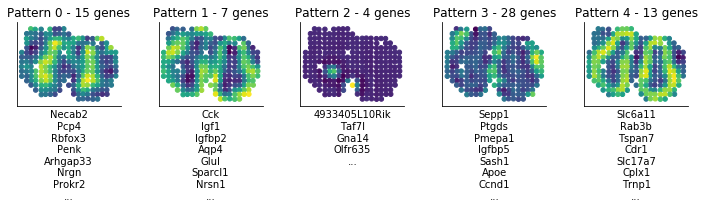

In [16]:
figsize(10, 3)
for i, Ci in enumerate(histology_results.sort_values('pattern').pattern.unique()):
    C = patterns[Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=20)
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(Ci, histology_results.query('pattern == @Ci').shape[0] ))
    
    xlab = '\n'.join(histology_results.query('pattern == @Ci').sort_values('membership')['g'].tolist()[:7])
    plt.xlabel(xlab + '\n...')
    
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig('MOB_AEH.pdf', bbox_inches='tight')

In [17]:
for i in histology_results.sort_values('pattern').pattern.unique():
    
    print('Pattern {}'.format(i))
    print(', '.join(histology_results.query('pattern == @i').sort_values('membership')['g'].tolist()))
    print()

Pattern 0
Necab2, Pcp4, Rbfox3, Penk, Arhgap33, Nrgn, Prokr2, Kcnh3, Camk2b, Baiap2, Gpsm1, Pbx1, Tubb2b, Ncdn, Mbp

Pattern 1
Cck, Igf1, Igfbp2, Aqp4, Glul, Sparcl1, Nrsn1

Pattern 2
4933405L10Rik, Taf7l, Gna14, Olfr635

Pattern 3
Sepp1, Ptgds, Pmepa1, Igfbp5, Sash1, Apoe, Ccnd1, Gng13, Foxd3, Unc13c, Kctd12, Mcf2l, Scd1, Nr2f2, Sorbs1, Kif5b, Omp, Lpar1, Trak2, Vtn, Marcks, S100a5, Apod, Fabp7, Frzb, Apc, Ptn, Sfrp5

Pattern 4
Slc6a11, Rab3b, Tspan7, Cdr1, Slc17a7, Cplx1, Trnp1, Atp1b1, Gabra1, Cpe, Doc2g, Slc1a2, Cdhr1



In [18]:
histology_results.sort_values('membership', ascending=False).head()

,g,membership,pattern
8279,Rab3b,1.0,4
8698,Necab2,1.0,0
10936,Scd1,1.0,3
10947,Cpe,1.0,4
11027,Aqp4,1.0,1


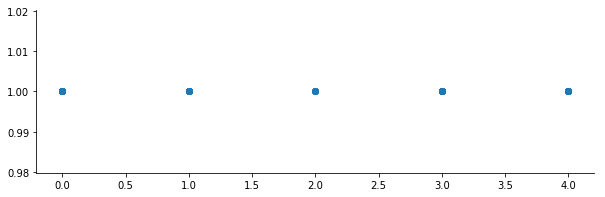

In [19]:
plt.scatter(histology_results.pattern, histology_results.membership);